In [6]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
# My Functions

def delayEmbed(Xin, Yin,assignment,embInterval):
    
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    # Yin = Yin[-X.shape[0]:]
    
    return (Xin, Yin)

def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

# Lyapunov Edition
def lyapunovExp(S):
    v = S.shape[1]
    P = np.zeros((S.shape[0]-1,2*S.shape[1]))
    P[:,:S.shape[1]] = S[:-1]
    P[:,S.shape[1]:] = S[1:]
    P = P[~np.isnan(P).any(axis=1)]
    
    Lexp = 0
    for i in range(P.shape[0]):
        nearNeighborsIndices = nearestNeighbors(P[i,:v], P[:,:v], 1)
        for nni in nearNeighborsIndices:
            currentDist = la.norm(P[i,:v] - P[nni,:v])
            nextStepDist = la.norm(P[i,v:] - P[nni,v:])
            if currentDist != 0 and nextStepDist != 0:
                fprime = nextStepDist / currentDist
                Lexp += np.log(fprime) # / la.norm(S[i] - S[nni])
    return Lexp / P.shape[0] # geometric mean - seems like lyapunov right?

# Slow Feature Analysis Functions
def nonlinearBasisExpand(x):
    n = x.shape[0]
    d = x.shape[1]
    
    M = int(d+d*(d+1)/2) # number of monomials and binomials
    
    hx = np.zeros((n,M))
    hx[:,0:d] = x
    ind = d
    for i in range(d):
        xi = x[:,i]
        for j in range(i,d):
            xj = x[:,j]
            hx[:,ind] = np.multiply(xi, xj)
            ind += 1
            
    return hx

def standardize(x):
    return (x - np.mean(x[np.isfinite(x)],axis=0)) / np.std(x[np.isfinite(x)],axis=0)

def linearSimilarity(d, c): # d = column vectors of drivers, c = column vector of "color" of lyapunov spectrum
    if c.ndim == 1:
        c = c.reshape((len(c),1))
    if d.ndim == 1:
        d = d.reshape((len(d),1))
        
    finiteVals = np.logical_and(np.all(np.isfinite(d),axis=1),np.all(np.isfinite(c),axis=1))
    dNoNAs = d[finiteVals]
    cNoNAs = c[finiteVals]
    
    dinv = la.inv(dNoNAs.T @ dNoNAs) @ dNoNAs.T
    k = dinv @ cNoNAs
    
    return (k, timeSeriesSimilarity((dNoNAs @ k).flatten(), cNoNAs.flatten()))

def timeSeriesSimilarity(t1, t2):
    return abs(np.dot(t1,t2) / (la.norm(t1) * la.norm(t2)))

In [4]:
file = "alldata.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
data = data.astype({"Abundance" : float})
print(data.info())

# print(data.isna().sum())

pd.option_context("display.max_rows","display.max_columns")

data.drop(["Level"],1,inplace=True)
# data.set_index(["Site","Month","Year"],inplace=True)
# display(data.query("Site == ['Lake Apopka (FL)'] and "))

for site in data["Site"].drop_duplicates():
    for species in data.query("Site == ['{s}']".format(s=site))["Name"].drop_duplicates():
        s = data.query("Site == ['{s}'] and Name == ['{n}']".format(s=site,n=species))
        print("len = {le}, NAs = {nas} : {l} population of {s} ".format(s=species,l=site, le=len(s), nas=s["Abundance"].isna().sum()) )

# Lake Geneva has alot of data points, some NAs, is not restricted use, but has crap temperature data
# Esthwaite Water Zooplankton has almost 0 NAs, good temp data, is of reasonable size, and is not restricted use - BINGO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175085 entries, 0 to 175084
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Site       175085 non-null  object 
 1   Year       175085 non-null  int64  
 2   Month      175085 non-null  int64  
 3   Name       175085 non-null  object 
 4   Abundance  142755 non-null  float64
 5   Level      175085 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 6.0+ MB
None
len = 324, NAs = 24 : Blelham Tarn (UK) population of Chla 
len = 324, NAs = 14 : Blelham Tarn (UK) population of Zooplankton 
len = 395, NAs = 12 : Esthwaite Water (UK) population of Chla 
len = 395, NAs = 2 : Esthwaite Water (UK) population of Zooplankton 
len = 395, NAs = 25 : Windermere North (UK) population of copepod 
len = 395, NAs = 25 : Windermere North (UK) population of large.clad 
len = 395, NAs = 25 : Windermere North (UK) population of small.clad 
len = 395, NAs = 11 : Winderm

c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


len = 212, NAs = 6 : Lake Apopka (FL) population of Chla 
len = 212, NAs = 20 : Lake Apopka (FL) population of Zooplankton 
len = 211, NAs = 22 : Lake Beauclair (FL) population of clad 
len = 211, NAs = 27 : Lake Beauclair (FL) population of copepod 
len = 211, NAs = 9 : Lake Beauclair (FL) population of Chla 
len = 211, NAs = 27 : Lake Beauclair (FL) population of Zooplankton 
len = 212, NAs = 28 : Lake Dora (FL) population of clad 
len = 212, NAs = 33 : Lake Dora (FL) population of copepod 
len = 212, NAs = 20 : Lake Dora (FL) population of Chla 
len = 212, NAs = 33 : Lake Dora (FL) population of Zooplankton 
len = 208, NAs = 21 : Lake Eustis (FL) population of clad 
len = 208, NAs = 26 : Lake Eustis (FL) population of copepod 
len = 208, NAs = 43 : Lake Eustis (FL) population of Chla 
len = 208, NAs = 26 : Lake Eustis (FL) population of Zooplankton 
len = 210, NAs = 18 : Lake Griffin (FL) population of clad 
len = 210, NAs = 23 : Lake Griffin (FL) population of copepod 
len = 210, N

len = 477, NAs = 15 : Lake Muggelsee population of Keratella cochlearis tecta 
len = 477, NAs = 15 : Lake Muggelsee population of Keratella quadrata 
len = 477, NAs = 15 : Lake Muggelsee population of Leptodora kindtii 
len = 477, NAs = 15 : Lake Muggelsee population of Mesocyclops leuckarti 
len = 477, NAs = 15 : Lake Muggelsee population of Polyarthra dolichoptera 
len = 477, NAs = 15 : Lake Muggelsee population of Polyarthra dolichoptera-vulgaris-Group 
len = 477, NAs = 15 : Lake Muggelsee population of Polyarthra spp.  
len = 477, NAs = 15 : Lake Muggelsee population of Pompholyx sulcata 
len = 477, NAs = 15 : Lake Muggelsee population of Rotifers spp. 
len = 477, NAs = 15 : Lake Muggelsee population of Synchaeta oblonga 
len = 477, NAs = 15 : Lake Muggelsee population of Synchaeta pectinata 
len = 477, NAs = 15 : Lake Muggelsee population of Synchaeta spp.  
len = 477, NAs = 15 : Lake Muggelsee population of Trichocerca similis 
len = 305, NAs = 128 : Narragansett Bay population o

len = 248, NAs = 136 : Strait of Georgia population of Calanoids.1to3mm 
len = 248, NAs = 150 : Strait of Georgia population of Calanoids.3to5mm 
len = 248, NAs = 150 : Strait of Georgia population of Calanoids.greater5mm 
len = 248, NAs = 138 : Strait of Georgia population of Total.Euphausiids.less1.cm 
len = 248, NAs = 138 : Strait of Georgia population of E.pacifica.less1cm 
len = 248, NAs = 138 : Strait of Georgia population of Thysanoessa.less1cm 
len = 248, NAs = 136 : Strait of Georgia population of Gammarids 
len = 248, NAs = 136 : Strait of Georgia population of Hyperiids 
len = 248, NAs = 136 : Strait of Georgia population of Ostracods 
len = 248, NAs = 169 : Strait of Georgia population of Shrimps 
len = 248, NAs = 169 : Strait of Georgia population of Crab.larvae 
len = 248, NAs = 136 : Strait of Georgia population of Chaetognaths 
len = 248, NAs = 136 : Strait of Georgia population of Pteropods 
len = 248, NAs = 169 : Strait of Georgia population of Larvaceans 
len = 248, 

len = 440, NAs = 160 : Trout Lake (WI) population of POLYARTHRA DOLICHOPTERA 
len = 440, NAs = 160 : Trout Lake (WI) population of POLYARTHRA MAJOR 
len = 440, NAs = 160 : Trout Lake (WI) population of POLYARTHRA REMATA 
len = 440, NAs = 160 : Trout Lake (WI) population of POLYARTHRA VULGARIS 
len = 440, NAs = 160 : Trout Lake (WI) population of SYNCHAETA 
len = 440, NAs = 172 : Trout Lake (WI) population of Chla 
len = 440, NAs = 160 : Trout Lake (WI) population of Zooplankton 


15
15
15


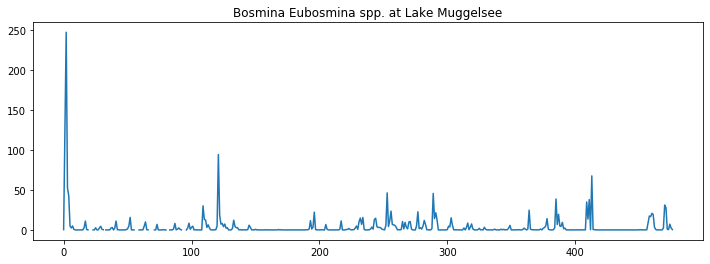

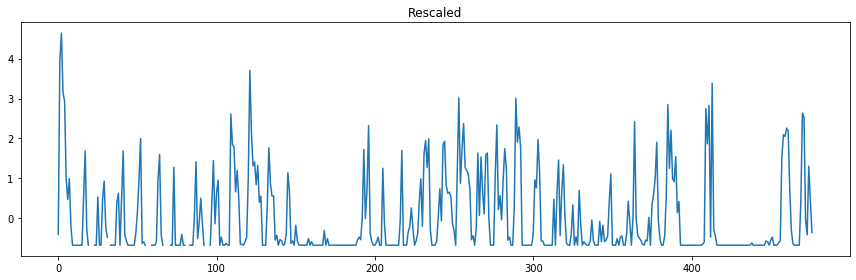

In [24]:
np.set_printoptions(precision=4, suppress=True)

location = "Lake Muggelsee"
species = "Bosmina Eubosmina spp."
EWdata = data.query("Site == ['{loc}'] and Name == ['{n}']".format(loc=location, n=species))["Abundance"].to_numpy()

"""
for species in EWdata["Name"].drop_duplicates():
    axWater[i].set_title("{s} at {l}".format(s=species,l=location))
    axWater[i].plot(EWdata.query("Name == ['{n}']".format(n=species))["Abundance"].to_numpy());
    i += 1
"""

print(np.sum(np.isnan(EWdata)))
Xr = EWdata - np.nanmin(EWdata) + 1
# Xr = EWdata + np.std( EWdata, axis = 0, where=np.isfinite(EWdata))
print(np.sum(np.isnan(EWdata)))

# Xr = standardize(np.sqrt(Xr, where = np.isfinite(Xr)))
Xr = np.log2(Xr + 0.1, where = np.isfinite(Xr+0.1), out=Xr) + 1
# Xr = Xr ** (1/10)
print(np.sum(np.isnan(Xr)))
# Xr = standardize(np.log(Xr, where = np.logical_and(np.isfinite(Xr), np.not_equal(Xr, Xr*0))))
# Now try without log transform
Xr = standardize(Xr) # RESULT - WORKS MUCH MORE CLEANLY WITH LOG TRANSFORM
# Xr = Xr[:175]
Xr = Xr.reshape(len(Xr),1)

ngraphs = 1
figWater, axWater = plt.subplots(ngraphs, figsize=(12,4*ngraphs))
# for location in data.index.levels[0][:3]:
axWater.set_title("{s} at {l}".format(s=species,l=location))
# axWater.plot(EWdata.query("Name == ['{n}']".format(n=species))["Abundance"].to_numpy());
axWater.plot(EWdata);

figPlank, axPlank = plt.subplots(figsize=(12,4))
axPlank.plot(Xr)
axPlank.set_title("Rescaled")
 
plt.tight_layout()
plt.show()

NAs at Blelham Tarn (UK) = 5
NAs at Esthwaite Water (UK) = 1
NAs at Windermere North (UK) = 0
NAs at Lake Apopka (FL) = 6
NAs at Lake Beauclair (FL) = 10
NAs at Lake Dora (FL) = 18
NAs at Lake Eustis (FL) = 43
NAs at Lake Griffin (FL) = 11
NAs at Lake Harris (FL) = 28
NAs at Lake Yale (FL) = 57
NAs at Lake Greifensee = 43
NAs at Lake Geneva = 79
NAs at Lake Kasumigaura = 12
NAs at Lake Mendota (WI) = 121
NAs at Loch Leven = 212
NAs at Lake Zurich = 53
NAs at Lake Muggelsee = 47
NAs at Narragansett Bay = 2
NAs at Lake Taupo = 15
NAs at Oneida Lake = 282
NAs at Big Muskellunge (WI) = 159
NAs at Crystal Bog (WI) = 172
NAs at Crystal Lake (WI) = 113
NAs at Sparkling Lake (WI) = 150
NAs at Trout Lake (WI) = 164


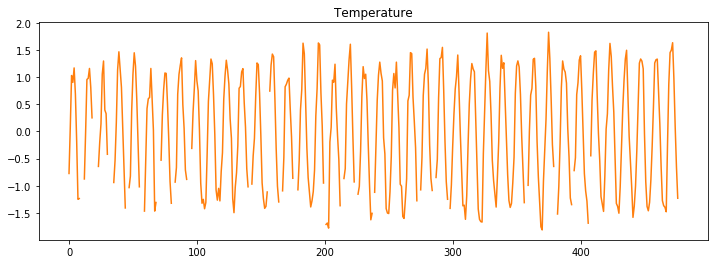

In [25]:
# Read out driver

file = "temperaturedata.csv"
driverData = pd.read_csv(file, encoding="utf-8", na_filter = True)
driverR = driverData.query("Site == ['{loc}']".format(loc=location))["Temp"].to_numpy()
driverR = driverR.reshape(len(driverR),1)
driverR = standardize(driverR)

driverR = driverR[:Xr.shape[0]]

for location in driverData["Site"].drop_duplicates():
    nNAs = np.sum(np.isnan(driverData.query("Site == ['{loc}']".format(loc=location))["Temp"]))
    print("NAs at {loc} = {nna}".format(loc = location, nna = nNAs))

figDr, axDr = plt.subplots(figsize = (12,4))
axDr.plot(driverR, color="tab:orange")
axDr.set_title("Temperature")
plt.show()

Null Correlation =  0.41375702120157754


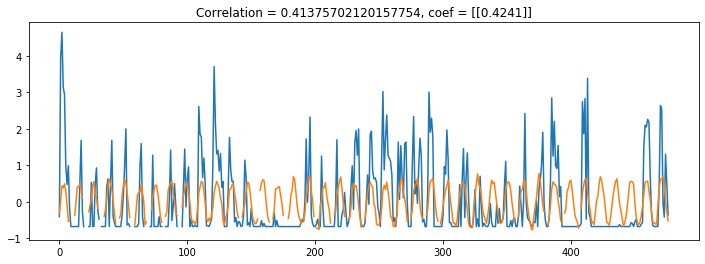

In [26]:
# Correlation between driver and original unaltered data
k, sim = linearSimilarity(driverR, Xr)
figCorr, axCorr = plt.subplots(1,figsize=(12,4))

axCorr.plot(Xr)
axCorr.plot(driverR @ k)
axCorr.set_title("Correlation = {c}, coef = {K}".format(c=sim, K=k))

print("Null Correlation = ", sim)

plt.show()

In [27]:
"""
tlen = 440
r = lambda t : 3.35 + 0.6 * np.sin(0.7*2*np.pi*t/tlen)
# r = lambda t : 0.5 * t / tlen + 3.5
states = np.zeros((tlen,1))
states[0,0] = 0.33333333
for t in range(1,tlen):
    states[t,0] = r(t) * states[t-1,0] * (1 - states[t-1,0])
Xr = states

figLog, axLog = plt.subplots(figsize=(12,4))
axLog.plot(Xr)
plt.show()
"""

'\ntlen = 440\nr = lambda t : 3.35 + 0.6 * np.sin(0.7*2*np.pi*t/tlen)\n# r = lambda t : 0.5 * t / tlen + 3.5\nstates = np.zeros((tlen,1))\nstates[0,0] = 0.33333333\nfor t in range(1,tlen):\n    states[t,0] = r(t) * states[t-1,0] * (1 - states[t-1,0])\nXr = states\n\nfigLog, axLog = plt.subplots(figsize=(12,4))\naxLog.plot(Xr)\nplt.show()\n'

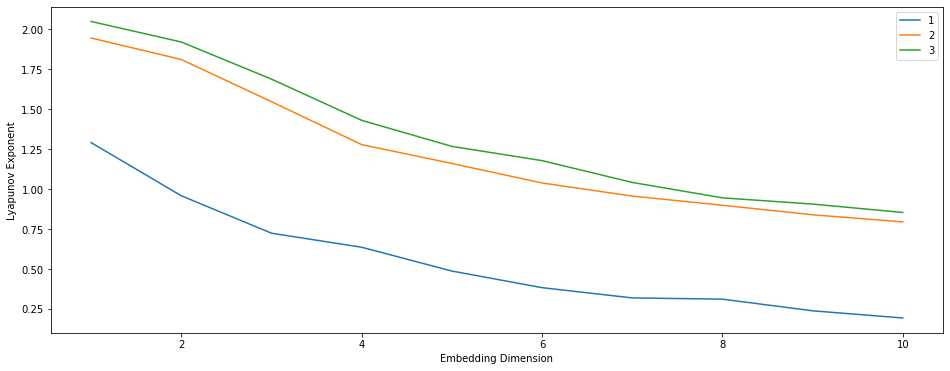

In [32]:
# False Nearest Neighbors Test

# Unitary Embedding Testing

dim = 1

l = 10
c = 1
st = 3

# figFNN, axFNN = plt.subplots(2 * c,figsize=(16, 3*(2*c)))
figFNN, axFNN = plt.subplots(c, figsize=(16, 6*c))
# figFNN = plt.figure(figsize=(12, 8))
# axFNN = figFNN.add_subplot()

for c in range(1, c+1):
    lyapExps = np.zeros(l)
    for s in range(1, st+1, 1):
        for i in range(1, l+1):
            Y, _ = delayEmbed(Xr[::c], Xr[::c], [i]*dim,s)
            # Y, _ = delayEmbedUnitary(Xr[::c], Xr[::c], i,s)
            lyapExps[i-1] = lyapunovExp(Y)
            
        axFNN.plot(range(1,l+1), lyapExps, label="{e}".format(e=s))

    axFNN.legend()
    axFNN.set_xlabel("Embedding Dimension")
    # axFNN[c-1].set_title("Slice = {ind}".format(ind=c))
    axFNN.set_ylabel("Lyapunov Exponent")
    
plt.show()

In [33]:
embDim = 7
stepSize = 1

X, _ = delayEmbed(Xr, Xr, [embDim]*dim,stepSize)
driver = driverR[embDim:]
print("X shape:", X.shape,"\nDriver shape: ",driver.shape)

X shape: (470, 8) 
Driver shape:  (470, 1)


In [34]:
# do SFA
"""
Xstd = standardize(X)
basisExpanded = nonlinearBasisExpand(Xstd)

# whitening - this is independent of the order of the values, so we can safely drop any NAs
NAsRemoved = basisExpanded[~np.any(np.isnan(basisExpanded),axis=1)]

U, S, V = la.svd(NAsRemoved)
whitened = U[:,:V.shape[0]] @ V

whitenedVal, whitenedVec = la.eigh(np.cov(NAsRemoved.T,bias=False))
whitened = NAsRemoved @ (whitenedVec @ np.diag((whitenedVal+1e-7) ** -0.5))


print("Mean Test : ", np.mean(whitened))
print("Covariance Test : \n",np.cov(whitened.T))

derivatives = whitened[1:,:] - whitened[:-1,:]
colors, spectrum = la.eigh(np.cov(derivatives, rowvar=False))

print("Colors = ",colors)
"""

'\nXstd = standardize(X)\nbasisExpanded = nonlinearBasisExpand(Xstd)\n\n# whitening - this is independent of the order of the values, so we can safely drop any NAs\nNAsRemoved = basisExpanded[~np.any(np.isnan(basisExpanded),axis=1)]\n\nU, S, V = la.svd(NAsRemoved)\nwhitened = U[:,:V.shape[0]] @ V\n\nwhitenedVal, whitenedVec = la.eigh(np.cov(NAsRemoved.T,bias=False))\nwhitened = NAsRemoved @ (whitenedVec @ np.diag((whitenedVal+1e-7) ** -0.5))\n\n\nprint("Mean Test : ", np.mean(whitened))\nprint("Covariance Test : \n",np.cov(whitened.T))\n\nderivatives = whitened[1:,:] - whitened[:-1,:]\ncolors, spectrum = la.eigh(np.cov(derivatives, rowvar=False))\n\nprint("Colors = ",colors)\n'

In [35]:
basisExpanded = nonlinearBasisExpand(X)
# basisExpandedSt = standardize(basisExpanded)
basisExpandedSt = basisExpanded - np.mean(basisExpanded[np.isfinite(basisExpanded)],axis=0)
print("NA Rows = ",np.sum(np.any(np.isnan(basisExpandedSt),axis=1)), basisExpandedSt.shape)

basisExpandedStNoNas = basisExpanded[np.all(np.isfinite(basisExpanded),axis=1)]

# Whitening!

# SVD Version - seems to be more numerically unstable than PCA, which is strange. Will use PCA for now but I should revist this
"""
U, S, V = la.svd(basisExpandedStNoNas)
whitened = basisExpandedSt @ V.T @ np.diag(1/S)

whitenedNoNas = whitened[np.all(np.isfinite(whitened),axis = 1)]

print("NA rows = ", np.sum(np.any(np.isnan(whitened),axis=1)), whitened.shape)
"""
# PCA Version
covPCA = np.cov(basisExpandedStNoNas.T) # cov is non nan
eigValPCA, eigVecPCA = la.eigh(covPCA)
print("PCA eigenvals(many 0 values suggest high redundancy in data) : \n",eigValPCA)

whitened = basisExpandedSt @ (eigVecPCA @ np.diag((eigValPCA+1e-7) ** -0.5))
whitenedNoNas = whitened[np.all(np.isfinite(whitened),axis = 1)]

"""
c = np.cov(zprime.T, bias=False, rowvar=True)
print("NAs = ", np.sum(np.isnan(c)))
# print("Covariance = ", c, c.shape)

eigval, eigvec = la.eigh(c)
# print("Eigenstuff = ", eigval, eigvec)
print("Eigenvals(shouldn't be near 0) ", eigval)

diagEigVal = np.diag((eigval+1e-7) ** -0.5)

print(zprime.shape, diagEigVal.shape, eigvec.T.shape)
z = zprime @ (eigvec @ diagEigVal)
"""
# print("z = ", z)
print("Mean test(should be 0)", np.mean(whitenedNoNas))
print("Covariance test(should be I): \n", np.cov(whitenedNoNas.T))
# print("Covariance test(should be I): \n", np.cov(whitened.T))

# Another PCA on derivatives
dWhiteneddt = whitened[1:,:] - whitened[:-1,:]
covdWhiteneddt = np.cov(dWhiteneddt[np.all(np.isfinite(dWhiteneddt),axis=1)].T)
colors, spectrum = la.eigh(covdWhiteneddt)

a = spectrum[:,np.argsort(colors)[0]] # eigVecDot.sort(key=eigValDot)[0]
# print(a)
yt = whitened @ a
print(a.shape, whitened.shape)


NA Rows =  58 (470, 44)
PCA eigenvals(many 0 values suggest high redundancy in data) : 
 [ 0.0367  0.0519  0.0654  0.0676  0.0744  0.076   0.0854  0.0963  0.1133
  0.1254  0.1351  0.1482  0.1698  0.2128  0.2174  0.2371  0.2506  0.2965
  0.3172  0.3296  0.3371  0.383   0.4374  0.4595  0.4962  0.5708  0.6698
  0.7676  0.8489  1.0311  1.1869  1.2791  1.3955  1.7858  2.074   2.6067
  2.6654  2.8051  2.8693  3.1079  4.179   7.1472 10.1964 18.259 ]
Mean test(should be 0) -0.006116991650544154
Covariance test(should be I): 
 [[ 1. -0. -0. ... -0.  0. -0.]
 [-0.  1.  0. ...  0. -0. -0.]
 [-0.  0.  1. ... -0. -0. -0.]
 ...
 [-0.  0. -0. ...  1.  0.  0.]
 [ 0. -0. -0. ...  0.  1. -0.]
 [-0. -0. -0. ...  0. -0.  1.]]
(44,) (470, 44)


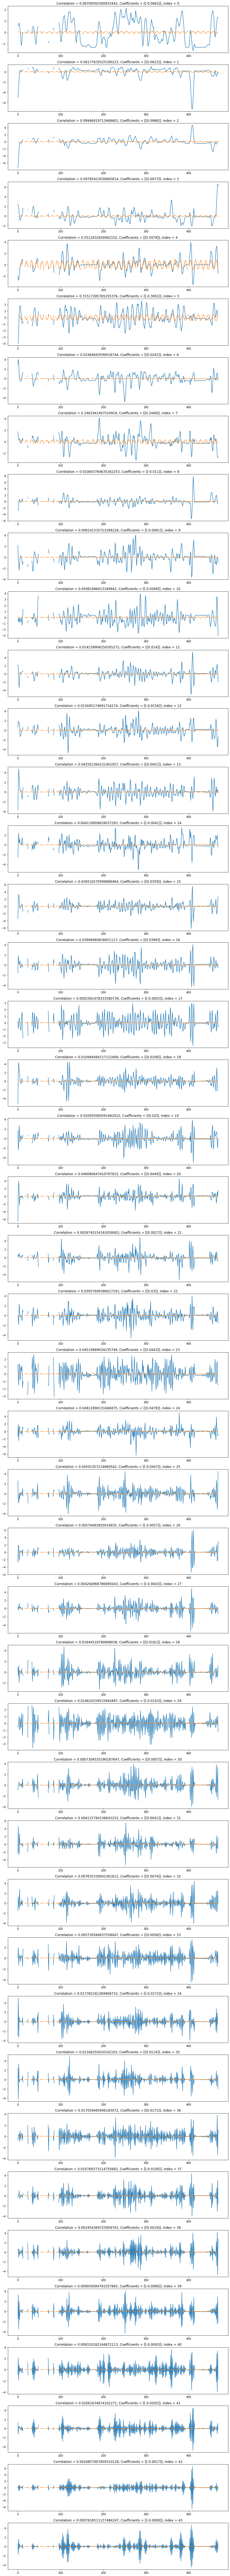

In [37]:
figSpectrum, axSpectrum = plt.subplots(len(colors), figsize=(12,3*len(colors)))

for i in range(len(colors)):
    projection = spectrum[:,i] @ whitened.T
    projectionSt = standardize(projection)
    
    k, sim = linearSimilarity(driver, projectionSt)
    
    axSpectrum[i].plot( projectionSt )
    axSpectrum[i].plot( driver @ k ,c="tab:orange")
    axSpectrum[i].set_title("Correlation = {c}, Coefficients = {K}, index = {I}".format(c=sim,K=k,I=i))
    
plt.tight_layout()
plt.show()

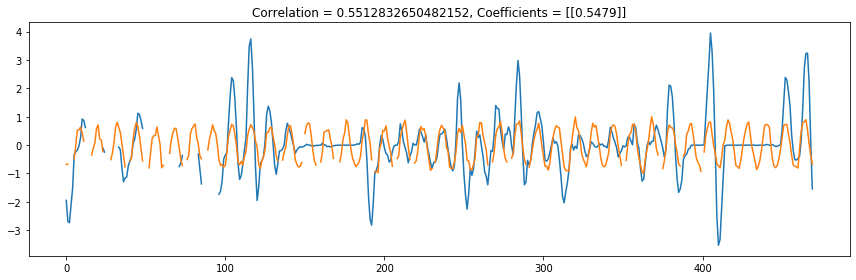

In [38]:
singleGraphIndex = 4

figSpectrum, axSpectrum = plt.subplots(1, figsize=(12,4))

projection = spectrum[:,singleGraphIndex] @ whitened.T
projectionSt = standardize(projection)

k, sim = linearSimilarity(driver, projectionSt)

axSpectrum.plot( projectionSt )
axSpectrum.plot( driver @ k ,c="tab:orange")
axSpectrum.set_title("Correlation = {c}, Coefficients = {K}".format(c=sim,K=k))
    
plt.tight_layout()
plt.show()

#### 